In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.utils import resample


In [3]:
df = pd.read_csv('/content/weather_prediction_dataset.csv')

In [4]:
df_classified = df[['BASEL_temp_mean', 'BASEL_humidity', 'BASEL_cloud_cover',
                    'BASEL_pressure', 'BASEL_precipitation']].copy()

def label_weather(row):
    if row['BASEL_precipitation'] > 0:
        return 'Rainy'
    elif row['BASEL_cloud_cover'] >= 6:
        return 'Cloudy'
    else:
        return 'Sunny'

def classify_temp(temp):
    if temp < 10:
        return "Cold"
    elif 10 <= temp <= 25:
        return "Moderate"
    else:
        return "Hot"

In [5]:
df_classified['WeatherCondition'] = df_classified.apply(label_weather, axis=1)
df_classified['TempRangeClass'] = df_classified['BASEL_temp_mean'].apply(classify_temp)
df_classified['RainLikelihood'] = df_classified['BASEL_precipitation'].apply(lambda x: 'Yes' if x > 0 else 'No')
df_classified['HumidityCloudProduct'] = df_classified['BASEL_humidity'] * df_classified['BASEL_cloud_cover']


In [6]:
print("\n🔍 Original Class Distribution (Before Upsampling):")
print(df_classified['WeatherCondition'].value_counts())


🔍 Original Class Distribution (Before Upsampling):
WeatherCondition
Rainy     1707
Sunny     1229
Cloudy     718
Name: count, dtype: int64


In [7]:
sunny = df_classified[df_classified['WeatherCondition'] == 'Sunny']
rainy = df_classified[df_classified['WeatherCondition'] == 'Rainy']
cloudy = df_classified[df_classified['WeatherCondition'] == 'Cloudy']

max_count = max(len(sunny), len(rainy), len(cloudy))

sunny_upsampled = resample(sunny, replace=True, n_samples=max_count, random_state=42)
rainy_upsampled = resample(rainy, replace=True, n_samples=max_count, random_state=42)
cloudy_upsampled = resample(cloudy, replace=True, n_samples=max_count, random_state=42)

df_balanced = pd.concat([sunny_upsampled, rainy_upsampled, cloudy_upsampled])


In [8]:
print("\nCurrent Dataset Size After Upsampling:")
print(f"Total Number of Samples: {df_balanced.shape[0]}")
print("\nNumber of Samples in Each Class:")
print(df_balanced['WeatherCondition'].value_counts())



Current Dataset Size After Upsampling:
Total Number of Samples: 5121

Number of Samples in Each Class:
WeatherCondition
Sunny     1707
Rainy     1707
Cloudy    1707
Name: count, dtype: int64


In [9]:
features = ['BASEL_temp_mean', 'BASEL_humidity', 'BASEL_cloud_cover',
            'BASEL_pressure', 'HumidityCloudProduct']

X = df_balanced[features]
y = df_balanced['WeatherCondition']

le_weather = LabelEncoder()
y_encoded = le_weather.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)



 Random Forest Accuracy: 90.73%
 Classification Report for Random Forest:
              precision    recall  f1-score   support

      Cloudy       0.88      0.92      0.90       341
       Rainy       0.89      0.83      0.86       342
       Sunny       0.95      0.97      0.96       342

    accuracy                           0.91      1025
   macro avg       0.91      0.91      0.91      1025
weighted avg       0.91      0.91      0.91      1025



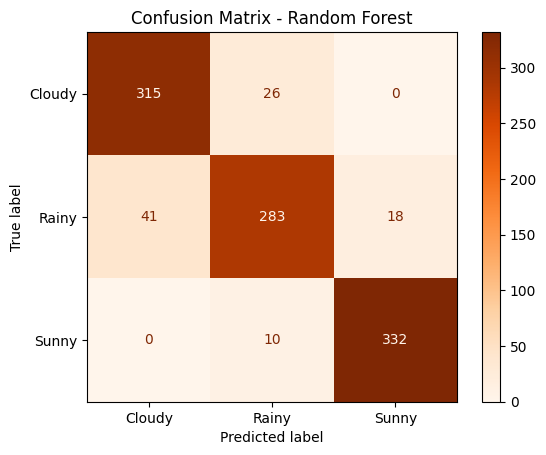

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost Accuracy: 91.61%
 Classification Report for XGBoost:
              precision    recall  f1-score   support

      Cloudy       0.90      0.93      0.92       341
       Rainy       0.90      0.85      0.87       342
       Sunny       0.95      0.97      0.96       342

    accuracy                           0.92      1025
   macro avg       0.92      0.92      0.92      1025
weighted avg       0.92      0.92      0.92      1025



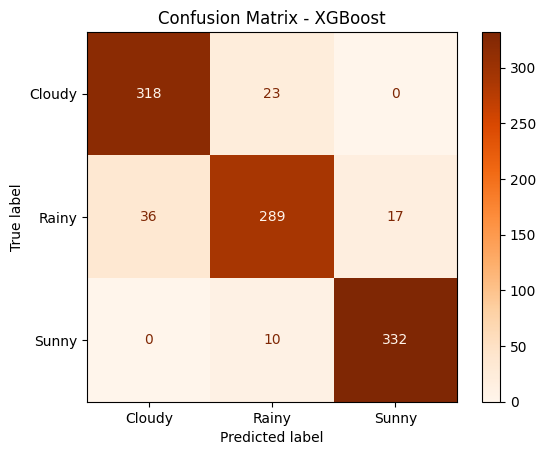


 Logistic Regression Accuracy: 68.49%
 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      Cloudy       0.63      0.59      0.61       341
       Rainy       0.53      0.54      0.53       342
       Sunny       0.89      0.92      0.90       342

    accuracy                           0.68      1025
   macro avg       0.68      0.68      0.68      1025
weighted avg       0.68      0.68      0.68      1025



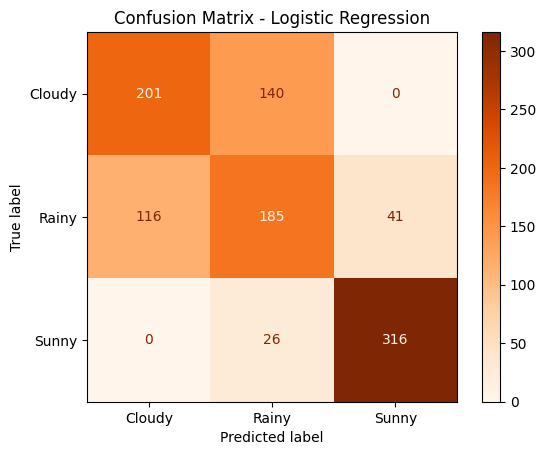


 SVM Accuracy: 72.49%
 Classification Report for SVM:
              precision    recall  f1-score   support

      Cloudy       0.65      0.73      0.69       341
       Rainy       0.62      0.47      0.53       342
       Sunny       0.87      0.98      0.92       342

    accuracy                           0.72      1025
   macro avg       0.71      0.72      0.71      1025
weighted avg       0.71      0.72      0.71      1025



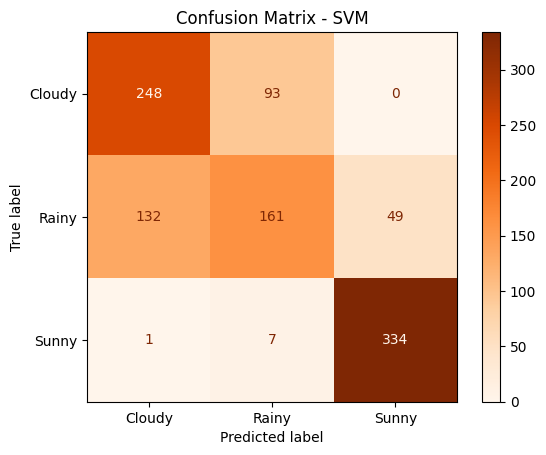


 KNN Accuracy: 74.93%
 Classification Report for KNN:
              precision    recall  f1-score   support

      Cloudy       0.71      0.75      0.73       341
       Rainy       0.64      0.58      0.61       342
       Sunny       0.89      0.92      0.91       342

    accuracy                           0.75      1025
   macro avg       0.75      0.75      0.75      1025
weighted avg       0.75      0.75      0.75      1025



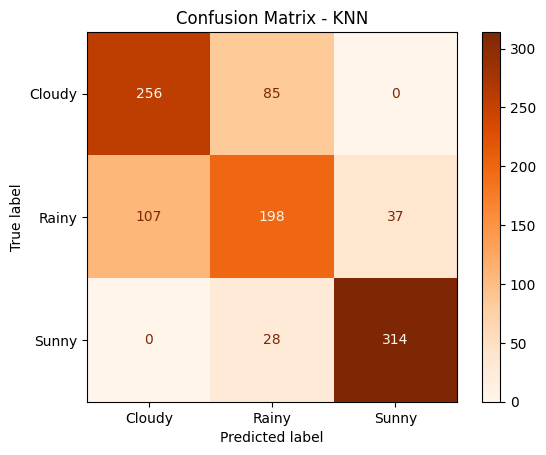

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

models = {
    'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[model_name] = acc * 100
    print(f"\n {model_name} Accuracy: {acc * 100:.2f}%")
    print(f" Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=le_weather.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_weather.classes_)
    disp.plot(cmap='Oranges')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

/tmp/ipython-input-11-2345326805.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.values()), y=list(results.keys()), palette='coolwarm')


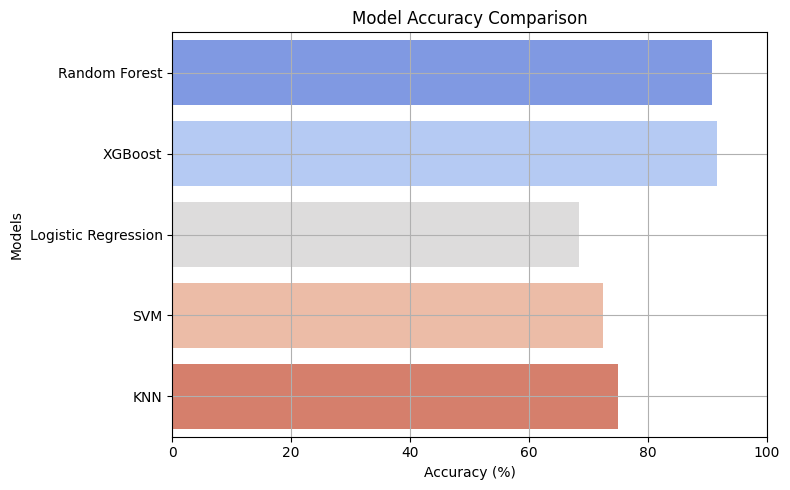

In [11]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.values()), y=list(results.keys()), palette='coolwarm')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy (%)')
plt.ylabel('Models')
plt.xlim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-12-1537467087.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='WeatherCondition', palette='Set2')


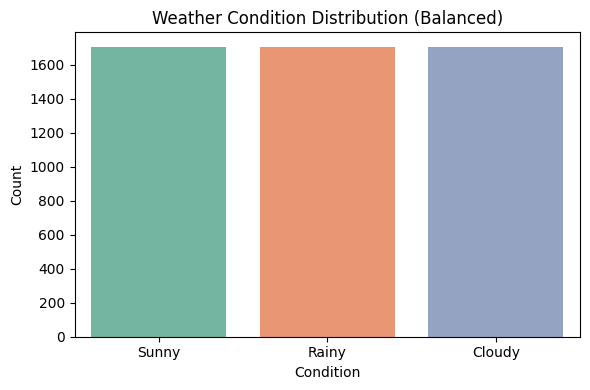

/tmp/ipython-input-12-1537467087.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='TempRangeClass', palette='coolwarm')


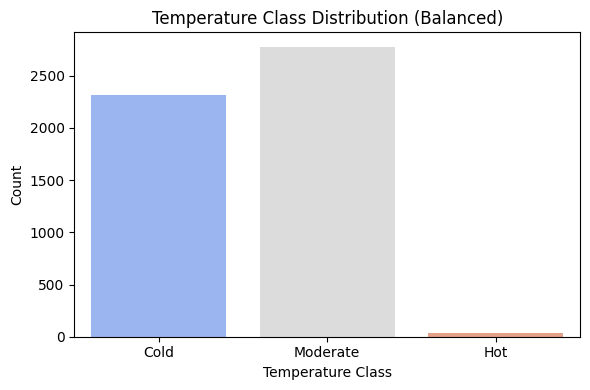

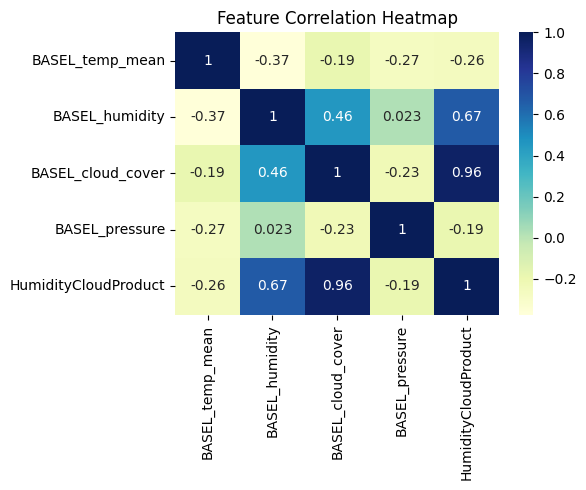

In [12]:
# 1. Weather Condition Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_balanced, x='WeatherCondition', palette='Set2')
plt.title('Weather Condition Distribution (Balanced)')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Temperature Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_balanced, x='TempRangeClass', palette='coolwarm')
plt.title('Temperature Class Distribution (Balanced)')
plt.xlabel('Temperature Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df_balanced[features].corr(), annot=True, cmap='YlGnBu')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [13]:
def full_weather_prediction(model, temp_mean, humidity, cloud_cover, pressure):
    input_data = np.array([[temp_mean, humidity, cloud_cover, pressure, humidity * cloud_cover]])
    weather_class = model.predict(input_data)
    weather_label = le_weather.inverse_transform(weather_class)[0]

    temp_class = classify_temp(temp_mean)
    rain_likelihood = "Yes" if cloud_cover >= 6 or weather_label == "Rainy" else "No"

    print("\n Prediction Summary:")
    print(f"→ Weather Condition: {weather_label}")
    print(f"→ Temperature Class: {temp_class}")
    print(f"→ Rain Likelihood: {rain_likelihood}")

    return {
        "WeatherCondition": weather_label,
        "TemperatureClass": temp_class,
        "RainLikelihood": rain_likelihood
    }


In [14]:
test_samples = [
    {'temp_mean': 12, 'humidity': 90, 'cloud_cover': 8, 'pressure': 1005},
    {'temp_mean': 26, 'humidity': 60, 'cloud_cover': 3, 'pressure': 1012},
    {'temp_mean': 18, 'humidity': 80, 'cloud_cover': 7, 'pressure': 1002},
    {'temp_mean': 30, 'humidity': 40, 'cloud_cover': 2, 'pressure': 1016},
    {'temp_mean': 22, 'humidity': 88, 'cloud_cover': 9, 'pressure': 1000}
]

for idx, sample in enumerate(test_samples, 1):
    print(f"\n Test Sample {idx}:")
    full_weather_prediction(models['XGBoost'], **sample)


 Test Sample 1:

 Prediction Summary:
→ Weather Condition: Rainy
→ Temperature Class: Moderate
→ Rain Likelihood: Yes

 Test Sample 2:

 Prediction Summary:
→ Weather Condition: Sunny
→ Temperature Class: Hot
→ Rain Likelihood: No

 Test Sample 3:

 Prediction Summary:
→ Weather Condition: Cloudy
→ Temperature Class: Moderate
→ Rain Likelihood: Yes

 Test Sample 4:

 Prediction Summary:
→ Weather Condition: Sunny
→ Temperature Class: Hot
→ Rain Likelihood: No

 Test Sample 5:

 Prediction Summary:
→ Weather Condition: Cloudy
→ Temperature Class: Moderate
→ Rain Likelihood: Yes
